<div style="text-align: center;">

# PREDICTING EMPLOYEE ATTRITION/BURNOUT

### Raúl Rodríguez y Gabriel Pons

#### Advanced Programming

##### January 2025

</div>

# Index

1. [Introduction](#introduction)
2. [Libraries and Dataset](#libraries-and-dataset)
3. [EDA](#eda)
4. [Setup](#setup)
5. [Basic Methods: Trees and KNN](#basic-methods-trees-and-knn)
6. [Results](#results)
7. [Final Model](final-model)
8. [Open Choice Task: XGboost](#an-additional-task)
9. [Feature Selection for KNN](#feature-selection-for-knn-1)

# 1. Introduction

In this assignment the objective is to work with business-critical problem of employee attrition prediction. A company is concerned about potential resignations to implement machine learning models to identify employees at risk of leaving. The provided dataset includes features related to employee demographics, professional characteristics, and workplace satisfaction, offering a foundation for predictive modeling.

This project emphasizes key machine learning concepts, including preprocessing techniques, hyperparameter optimization, and model evaluation. Using methods like K-Nearest Neighbors (KNN), decision trees, and dummy classifiers. THe idea is to train the model and predict in the best way the attrition between employees, choosing the best model between all our possibilities. It is done exploring default configurations and optimized solutions, comparing their performance with metrics such as accuracy, balanced accuracy, and confusion matrices.

Also the time spent by each algorithm si calculated in order to show us another important feature for the different models: the computational cost and efficiency

Additionally, advanced steps such as feature selection and a new oursself provided task gives opportunities for deeper exploration and refinement of the predictive models. The goal is to deliver not only a high-performing predictive model but also insights into the factors influencing employee attrition, providing to the firm new ways of strategic decision-making for workforce retention.

In our case, Gabi's ID is used to choose the dataset. In pur case it is `attrition_availabledata_05.csv`. THe random state used in the different code chunks is `random_state=100536214`.

# 2. Libraries and Dataset

All used libraries are defined in the following chunk:

In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from time import perf_counter
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, RobustScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from joblib import dump, load
import xgboost as xgb
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import SelectKBest, f_classif


In [40]:
file_path = 'attrition_availabledata_05.csv'
df = pd.read_csv(file_path)

After analysing the dataset, the first step is to separate the response variable (`y=Attrition`) from the dependent ones.

In [41]:
X = df.drop(columns='Attrition')
y = df['Attrition'] 
y

0       Yes
1        No
2        No
3        No
4        No
       ... 
2935     No
2936    Yes
2937     No
2938     No
2939     No
Name: Attrition, Length: 2940, dtype: object

# 3. EDA

### Dataset shape

In [42]:
X.shape

(2940, 30)

There are 2940 observations and 29 features plus the ID

### Dropping Constant and ID columns 

The first approach to see which columns are constant was to apply the function value_counts(), which outputs all the different values of the column and their frecuencies. Cheking if it's shape it's equal to 1  will determine if the column is a constant (other option is to check if the frecuency is equal to 2940). 

In [43]:
to_drop = [col for col in X.columns if X[col].value_counts().shape[0] == 1]
to_drop

['EmployeeCount', 'Over18', 'StandardHours']

The list `to_drop` is created in order to store the features that are going to be removed after exploring the data. 

It's important to add that the function `value_counts()` by default doesn't take into account missing values. In our case this doesn't affect us, because if a constant column has missing values, it will be constant either way. If we wanted to see if a column has missing values and how many, we should add `dropna=False`.

In [44]:
to_drop.append('EmployeeID')

In [45]:
X.drop(columns=to_drop, inplace=True)
X.shape

(2940, 26)

Finally, we have 26 useful varaibles to predict `Attrition`.

### Duplicated Observations

In [46]:
duplicates = X.duplicated().sum()
duplicates

np.int64(0)

There are no duplicated observations

### Problem Type

In [47]:
df['Attrition']

0       Yes
1        No
2        No
3        No
4        No
       ... 
2935     No
2936    Yes
2937     No
2938     No
2939     No
Name: Attrition, Length: 2940, dtype: object

As the target is a binary variable, we are facing a classification problem. To see the original distribution of this classification, the percentage of `Yes` and `No` can be performed.

In [48]:
y[y == 'Yes'].shape[0]/y.shape[0]*100 

16.122448979591837

An easier way is to use again `value_counts` with the parameter `normalize = True`. This shows the relative frecuency of each class instead of the whole count.  

In [49]:
y.value_counts(normalize=True)

Attrition
No     0.838776
Yes    0.161224
Name: proportion, dtype: float64

The data set is imbalanced. It only contains 16% of observations with the category Yes. Due to this, we are going to apply stratified cross validation.

### Missing values

In [50]:
missing_values = X.isna().sum()
missing_columns = missing_values[missing_values > 0]
missing_columns

Series([], dtype: int64)

As it was said during the lessons, this dataset doesn't have missing values. This is why this part isn't included in the pipeline.

### Categorical and Numerical Features

In [51]:
numerical_columns = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]
numerical_columns

['hrs',
 'absences',
 'JobInvolvement',
 'PerformanceRating',
 'EnvironmentSatisfaction',
 'JobSatisfaction',
 'WorkLifeBalance',
 'Age',
 'DistanceFromHome',
 'Education',
 'JobLevel',
 'MonthlyIncome',
 'NumCompaniesWorked',
 'PercentSalaryHike',
 'StockOptionLevel',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'YearsAtCompany',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager']

It is an usual approach to obtain the correlation matrix to avoid redundancy between numerical variables, but in this project, the feature selection is covered later on. Just out of curiosity, we have obtained it to see how the variables behave. 

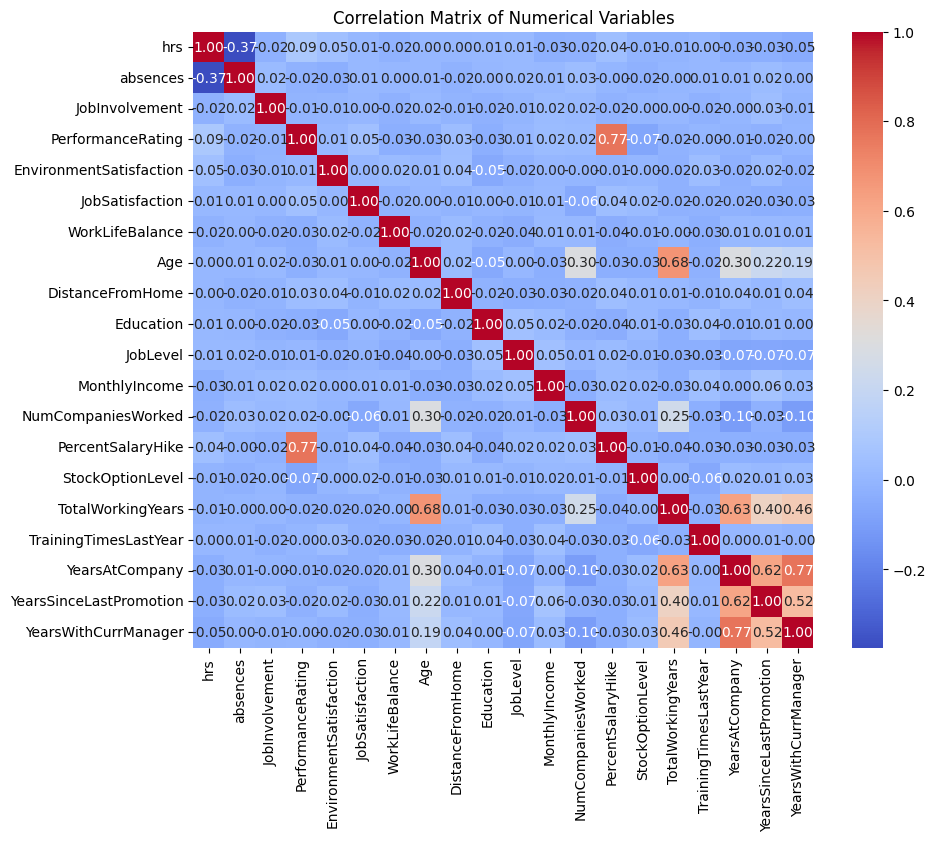

In [52]:
X_corr = X[numerical_columns]

correlation_matrix = X_corr.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Numerical Variables")
plt.show()

In [53]:
categorical_columns = [col for col in X.columns if col not in numerical_columns]
categorical_columns

['BusinessTravel',
 'Department',
 'EducationField',
 'Gender',
 'JobRole',
 'MaritalStatus']

### High Cardinality Features

In [54]:
HC_columns = [col for col in categorical_columns if X[col].value_counts().shape[0] >= 10] # If a variable has more than 10 categories it will be added to the list
HC_columns

[]

No categorical feature has 10 or more categories. This means there are no high cardinality features. An example would have been the ID (if it wasn't coded as numeric and if it wasn't erased before).

# 4. SET UP

### Data partition

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=100536214)

# Check class distribution in the original, training, and test sets
print("Training distribution:\n", y_train.value_counts(normalize=True), "\n")
print("Test distribution:\n", y_test.value_counts(normalize=True))

Training distribution:
 Attrition
No     0.838861
Yes    0.161139
Name: proportion, dtype: float64 

Test distribution:
 Attrition
No     0.838435
Yes    0.161565
Name: proportion, dtype: float64


Maintaining the class proportions through stratification is crucial in scenarios where the target variable is imbalanced because it ensures that both the training and test sets reflect the original dataset's distribution and fair and consistent representation of all classes across splits. This helps prevent the model from being biased toward the majority class during training and ensures that the test set provides a realistic evaluation of the model's performance. Without stratification, random splitting might result in one set having disproportionately more samples of one class, leading to unreliable training and testing results.

# 5. Basic Methods: K-Nearest neighbors and Decision trees

### Preprocessing functions

In [56]:
categories = [list(X[col].unique()) for col in categorical_columns]

for col, category in zip(categorical_columns, categories):
    print(col, ':',category)

BusinessTravel : ['Travel_Frequently', 'Travel_Rarely', 'Non-Travel']
Department : ['Sales', 'Human Resources', 'Research & Development']
EducationField : ['Technical Degree', 'Marketing', 'Medical', 'Life Sciences', 'Other', 'Human Resources']
Gender : ['Female', 'Male']
JobRole : ['Research Director', 'Sales Executive', 'Laboratory Technician', 'Manager', 'Research Scientist', 'Healthcare Representative', 'Manufacturing Director', 'Sales Representative', 'Human Resources']
MaritalStatus : ['Married', 'Single', 'Divorced']


This creates a list of unique categories for each column in `categorical_columns` and helps understand the possible values in categorical variables and ensures the data is ready for encoding.

In [57]:
ordinal_features = ['BusinessTravel']
non_ordinal_features = categorical_columns.copy()
non_ordinal_features.remove('BusinessTravel')

From the categorical variables, only `BusinessTravel` is identified as an ordinal variable. 

In [58]:
ordinal_transformer = OrdinalEncoder(categories=[['Non-Travel', 'Travel_Rarely', 'Travel_Frequently']])
non_ordinal_transformer = OneHotEncoder(handle_unknown='ignore')

In [59]:
cv = KFold(n_splits=5, shuffle=True, random_state=100536214)

Defining `cv` we ensure a 5-fold cross-validation strategy.

Using 5 folds for cross-validation is particularly effective for imbalanced datasets like ours, where 86% of the response variable is "No". This approach ensures that each fold maintains the original class distribution, providing a robust estimate of model performance across all data. Compared to smaller number of folds, it uses a larger training set, reducing bias and improving representation of the minority class. Compared to bigger number of folds, it minimizes computational costs while avoiding excessively small validation sets, which could worsen the evaluation of the minority class. 

In [60]:
inner_scores = {}

In the empty diccitonary `inner_scores` is going to be saved the different data for every KNN and Decision Tree model. This data is:

- Balanced Accuracy
- Runtime (s)

Choosing balanced accuracy over accuracy is crucial to ensure a fair evaluation of the model's performance across both classes. Accuracy could be misleading, as it tends to favor the majority class and overlook the minority class. Balanced accuracy, on the other hand, accounts for the performance on both classes by averaging the recall for each class, providing a more reliable metric for evaluating models on imbalanced datasets. 

### Dummy Model

Discalimer about registered execution time: as every computer is different, the reproducibility of this times is not possible. If the notebook is runned again any quantitative comment about time will not match. This values are not going to change  much.


In [61]:
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=100536214)

# Starts counting running time
start_time = perf_counter()

dummy_scores = cross_val_score(dummy_clf, X_train, y_train, scoring= 'balanced_accuracy', cv=cv)

# Stops counting running time
end_time = perf_counter()

# Total time is obtained substracting both 
dummy_run_time = end_time - start_time

print(f"The average cross validation balanced accuracy is: {dummy_scores.mean():.2f} ± {dummy_scores.std():.2f}")
print(f"The execution time is: {dummy_run_time:.2f}")

# Save the balanced accuracy and the execution time in the dicctionary
inner_scores['Dummy Model'] = {
    'Balanced Accuracy': dummy_scores.mean(),
    'Runtime (s)': dummy_run_time
}

The average cross validation balanced accuracy is: 0.50 ± 0.00
The execution time is: 0.02


This model achieves a balanced accuracy of 50% as expected for the `most frequent` strategy in an imbalanced dataset. Its predictions only cover the majority class, making it computationally efficient (0.02 seconds) but lacking predictive power. This establishes a baseline for comparison, with any meaningful model needing significantly higher balanced accuracy to demonstrate its effectiveness.

### KNN Standard Scaler Pipeline (Default)

The K-Nearest Neighbors (KNN) algorithm is a simple yet powerful supervised learning method. It operates based on the principle of proximity, where an unclassified data point is assigned the majority label of its closest $ k $ neighbors (for classification) or the average of their values (for regression). The distance between points, often measured using metrics like Euclidean or Manhattan distance, determines the neighbors. KNN is non-parametric, meaning it makes no assumptions about the underlying data distribution, and its performance relies heavily on the choice of $ k $, distance metric, and data scaling, especially in high-dimensional or imbalanced datasets.

In [62]:
knn = KNeighborsClassifier()

std_preprocessor = ColumnTransformer(
    transformers = [
        ('ord', ordinal_transformer, ordinal_features),
        ('non_ord', non_ordinal_transformer, non_ordinal_features),
        ('numerical', StandardScaler(), numerical_columns)
        
    ],
        remainder='passthrough')

standard_knn_pipeline = Pipeline([
    ('preprocessor', std_preprocessor),    
    ('knn', knn)                     
])

In [63]:
start_time = perf_counter()

standard_default_scores = cross_val_score(standard_knn_pipeline, X_train, y_train, scoring='balanced_accuracy', cv=cv)

end_time = perf_counter()

standard_default_time = end_time - start_time

print(f"The average cross validation balanced accuracy is: {standard_default_scores.mean():.2f} ± {standard_default_scores.std():.2f}")
print(f"The execution time is: {standard_default_time:.2f}")

inner_scores['KNN Standard Default'] = {
    'Balanced Accuracy': standard_default_scores.mean(),
    'Runtime (s)': standard_default_time
}

The average cross validation balanced accuracy is: 0.64 ± 0.02
The execution time is: 0.12


This KNN model was evaluated using a pipeline that preprocesses ordinal, non-ordinal, and numerical features with appropriated encoders and `StandardScaler` mode. The results show a balanced accuracy of 64% (0.64 ± 0.02), significantly better than the dummy model's baseline of 50%. The standard deviation of 0.02 indicates consistent performance across folds. The runtime was 0.12 seconds, demonstrating computational efficiency for this KNN default model.

In order to choose between `RobusstScaler` an other scalers, the outliers of the numerical variables have been computed. The RobustScalers is supposed to work better when facing with features with a high volume of outliers. 

$$Robust Scaler(x_{ij}) = \frac{x_{ij} - median(x_j)}{IQR(x_j)}$$ 

- Being $i$ the observation number and $j$ the feature

### Outlier detection

In [64]:
X_numeric = X_train[numerical_columns]
Q1 = X_numeric.quantile(0.25)
Q3 = X_numeric.quantile(0.75)
IQR = Q3 - Q1
outliers = ((X_numeric < (Q1 - 1.5 * IQR)) | (X_numeric > (Q3 + 1.5 * IQR)))
outliers_count = outliers.sum()
print("Number of outliers in each column:")
print(outliers_count)

Number of outliers in each column:
hrs                         78
absences                     0
JobInvolvement               0
PerformanceRating          361
EnvironmentSatisfaction      0
JobSatisfaction              0
WorkLifeBalance              0
Age                          0
DistanceFromHome             0
Education                    0
JobLevel                     0
MonthlyIncome              199
NumCompaniesWorked          82
PercentSalaryHike            0
StockOptionLevel           124
TotalWorkingYears          112
TrainingTimesLastYear      383
YearsAtCompany             163
YearsSinceLastPromotion    167
YearsWithCurrManager        21
dtype: int64


The analysis reveals that several numerical features, such as `PerformanceRating`, `MonthlyIncome`, `TrainingTimesLastYear`, and others, contain a significant number of outliers. Given this, the `RobustScaler` is a suitable choice for preprocessing as it is specifically designed to handle outliers effectively by scaling features based on the interquartile range, ensuring that extreme values do not unduly influence the model's performance.

### KNN Robust Scaler Pipeline (Default)

In [65]:
robust_preprocessor = ColumnTransformer(
    transformers = [
        ('ord', ordinal_transformer, ordinal_features),
        ('non_ord', non_ordinal_transformer, non_ordinal_features),
        ('numerical', RobustScaler(), numerical_columns)
        
    ],
        remainder='passthrough')

robust_knn_pipeline = Pipeline([
    ('preprocessor', robust_preprocessor),
    ('knn', knn)                     
])

In [66]:
start_time = perf_counter()


robust_default_scores = cross_val_score(robust_knn_pipeline, X_train, y_train, scoring='balanced_accuracy', cv=cv)

end_time = perf_counter()

robust_run_time = end_time - start_time

print(f"The average cross validation balanced accuracy is: {robust_default_scores.mean():.2f} ± {robust_default_scores.std():.2f}")
print(f"The execution time is: {robust_run_time:.2f}")

inner_scores['KNN Robust Default'] = {
    'Balanced Accuracy': robust_default_scores.mean(),
    'Runtime (s)': robust_run_time
}

The average cross validation balanced accuracy is: 0.61 ± 0.03
The execution time is: 0.14


Now, KNN is evaluated using a pipeline that preprocesses features with the same encoders and `RobustScaler`, which is less sensitive to outliers compared to `StandardScaler`. The 5-fold cv yielded a balanced accuracy of 61% (0.61 ± 0.03), slightly lower than the 64% (0.64 ± 0.02) achieved with the StandardScaler pipeline. The variability is slightly higher, with a standard deviation of 0.03 compared to 0.02. The runtime was 0.14 seconds.

Although the balanced accuracy is slightly lower, the use of `RobustScaler` will be preferred to ensure preprocessing is resilient to extreme values. Further optimization of the KNN pipeline may improve results while preserving robustness to outliers.

### KNN with HPO

#### KNN Grid Search

In [67]:
#from sklearn.metrics import classification_report, roc_auc_score

start_time = perf_counter()

# Hiyperparameters for KNN
param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9, 11],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan', 'minkowski']
}


# Grid search
# Use the pipeline as the estimator
knn_grid_search = GridSearchCV(
    robust_knn_pipeline, param_grid, cv=cv, scoring='balanced_accuracy', n_jobs=-1
)

knn_grid_search.fit(X_train, y_train)

end_time = perf_counter()
knn_HPO_time = end_time - start_time

# Save the best model
knn_HPO_model = knn_grid_search.best_estimator_

# Print the best parameters and best score
print(f"Best Parameters: {knn_grid_search.best_params_}")
print(f"Best Balanced Accuracy: {knn_grid_search.best_score_:.2f}")
print(f"The execution time is: {knn_HPO_time:.2f}")

inner_scores['KNN HPO'] = {
    'Balanced Accuracy': knn_grid_search.best_score_,
    'Runtime (s)': knn_HPO_time
}

Best Parameters: {'knn__metric': 'manhattan', 'knn__n_neighbors': 3, 'knn__weights': 'distance'}
Best Balanced Accuracy: 0.86
The execution time is: 5.58


c:\Users\Gabriel\anaconda3\envs\MULTI\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [0.69157844 0.83846453 0.60967706 0.79626374 0.60398701 0.78667665
 0.58290318 0.7543872  0.56940799 0.73746067        nan 0.86338443
        nan 0.86038935        nan 0.85126445        nan 0.83755636
        nan 0.83231509 0.69157844 0.83846453 0.60967706 0.79626374
 0.60398701 0.78667665 0.58290318 0.7543872  0.56940799 0.73746067]
  warnings.warn(


This process involves hyperparameter optimization (HPO) for the KNN model using `GridSearchCV`. The parameter grid includes options for the number of neighbors, weighting strategies, and distance metrics. The best configuration identified was 3 neighbors, `distance` weights, and `manhattan` metric, achieving a balanced accuracy of 86% (0.86), a significant improvement over the default KNN pipeline (61% with `RobustScaler`). The runtime for the HPO process was 5.58 seconds, reflecting the computational cost of evaluating multiple parameter combinations. Some test scores were non-finite (`NaN`), likely due to incompatible hyperparameter settings. Overall, the optimized KNN model demonstrates strong performance, justifying the use of HPO to improve predictive accuracy.

In [68]:
# We get all hyperparameters and their evaluation as a dataframe
cv_results_df = pd.DataFrame(knn_grid_search.cv_results_).loc[:,['params', 'mean_test_score']]

# Now, sort by score. Best hyper-parameters at the top
cv_results_df = cv_results_df.sort_values(by=['mean_test_score'], ascending=False)

# Set the maximum column width to display full content
pd.set_option('display.max_colwidth', None)
cv_results_df.iloc[:10,]

params  \
11   {'knn__metric': 'manhattan', 'knn__n_neighbors': 3, 'knn__weights': 'distance'}   
13   {'knn__metric': 'manhattan', 'knn__n_neighbors': 5, 'knn__weights': 'distance'}   
15   {'knn__metric': 'manhattan', 'knn__n_neighbors': 7, 'knn__weights': 'distance'}   
21   {'knn__metric': 'minkowski', 'knn__n_neighbors': 3, 'knn__weights': 'distance'}   
1    {'knn__metric': 'euclidean', 'knn__n_neighbors': 3, 'knn__weights': 'distance'}   
17   {'knn__metric': 'manhattan', 'knn__n_neighbors': 9, 'knn__weights': 'distance'}   
19  {'knn__metric': 'manhattan', 'knn__n_neighbors': 11, 'knn__weights': 'distance'}   
3    {'knn__metric': 'euclidean', 'knn__n_neighbors': 5, 'knn__weights': 'distance'}   
23   {'knn__metric': 'minkowski', 'knn__n_neighbors': 5, 'knn__weights': 'distance'}   
5    {'knn__metric': 'euclidean', 'knn__n_neighbors': 7, 'knn__weights': 'distance'}   

    mean_test_score  
11         0.863384  
13         0.860389  
15         0.851264  
21         0.838465  
1          0.838465  
17         0.837556  
19         0.832315  
3          0.796264  
23         0.796264  
5          0.786677

This dataframe is created in order to see how far is the best model from the others. The difference between 3 and 5 neighbors it's pretty small. In a real case scenario, if overfitting is detected with predicitions of future available data, there is a chance that increasing $k$ = 5 maybe can make a differnce.

We can expand our parameter grid and reduce the computational time taken using the function `RandomizedSearchCV`.

#### KNN Random Search

In [69]:
param_grid = {
    'knn__n_neighbors': sp_randint(3, 30),            
    'knn__weights': ['uniform', 'distance'],          
    'knn__metric': ['euclidean', 'manhattan', 'minkowski'],  
    'knn__p': sp_randint(1, 3),                      # Minkowski metric power
    'knn__leaf_size': sp_randint(10, 50),             # Leaf size for tree algorithms
    'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'knn__leaf_size': [10, 20, 30, 40, 50]
}

start_time = perf_counter()

# Randomized search
knn_random_search = RandomizedSearchCV(
    robust_knn_pipeline,
    param_distributions=param_grid,
    n_iter=100,  # Number of parameter combinations to test
    cv=cv,  
    scoring='balanced_accuracy',
    n_jobs=-1,  # Use all CPU cores
    random_state=100536214,
    return_train_score=True
)


knn_random_search.fit(X_train, y_train)

end_time = perf_counter()
knn_random_HPO_time = end_time - start_time

# Best model and parameters
knn_random_HPO_model = knn_random_search.best_estimator_
best_params = knn_random_search.best_params_
best_score = knn_random_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Balanced Accuracy: {best_score:.2f}")
print(f"Execution Time: {knn_random_HPO_time:.2f} seconds")

inner_scores['KNN Random HPO'] = {
    'Balanced Accuracy': best_score,
    'Runtime (s)': knn_random_HPO_time
}


Best Parameters: {'knn__algorithm': 'auto', 'knn__leaf_size': 40, 'knn__metric': 'manhattan', 'knn__n_neighbors': 3, 'knn__p': 2, 'knn__weights': 'distance'}
Best Balanced Accuracy: 0.86
Execution Time: 15.00 seconds


c:\Users\Gabriel\anaconda3\envs\MULTI\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [0.56940799 0.85126445        nan        nan        nan 0.83231509
 0.54370201 0.56330572 0.78667665        nan 0.56940799 0.69831304
        nan 0.5180323  0.83231509 0.65329887 0.86338443 0.66214438
 0.54370201 0.7799783  0.5885082         nan 0.75980167 0.52288334
 0.75759066 0.86338443 0.80115435 0.75323339 0.58607071 0.66989677
 0.75323339 0.83755636 0.57677026 0.60398701 0.54699199 0.55021685
 0.7317419  0.84062342 0.5389906  0.78667665 0.85126445 0.69831304
 0.80438037 0.69831304        nan 0.53925944 0.74129695 0.69157844
 0.66453994 0.74129695 0.54829886 0.74946755 0.69831304 0.56940799
 0.66453994 0.66214438 0.81890222 0.53925944 0.81859302        nan
 0.52288334 0.7919695  0.70938762 0.55021685 0.52508683        nan
 0.66214438 0.7919695  0.53061665 0.70938762 0.78557014 0.75323339
 0.86235688 0.83231509 0.66729258 0.525

This process uses `RandomizedSearchCV` for hyperparameter optimization (HPO) of the KNN model, testing 100 random combinations of hyperparameters. The best configuration identified includes 3 neighbors, `distance` weights, `manhattan` metric, and a leaf size of 40 (the rest parameters are set as default), achieving a balanced accuracy of 86% (0.86), same as the grid search results. The execution time was 15 seconds, significantly longer than grid search (5.58 seconds) due to the larger hyperparameter space explored.

Despite the increased computational cost, the results reinforce the model's optimal configuration, confirming its strong and consistent performance with the dataset. Randomized search is effective for exploring large hyperparameter spaces, but grid search becomes computationally less expensive in this case reaching the same balanced accuracy.

### Decision tree Pipeline

Decision trees are a supervised learning model that splits data into subsets based on feature values, creating a 'tree' structure. Each node represents a decision or condition, and 'leaves' represent class labels or outcomes. It is versatile, handling both categorical and numerical data without requiring scaling, and naturally accounts for non-linear relationships.

In [70]:
decision_tree = DecisionTreeClassifier(random_state=100536214)

In [71]:
tree_preprocessor = ColumnTransformer(
    transformers=[
        ('ord', OrdinalEncoder(categories=[['Non-Travel', 'Travel_Rarely', 'Travel_Frequently']]), ordinal_features), # We have used the function directly becaused I gave us problems during HPO
        ('non_ord', OneHotEncoder(handle_unknown='ignore'), non_ordinal_features)
    ],
    remainder='passthrough'
)


decision_tree = DecisionTreeClassifier(random_state=100536214)
tree_pipeline = Pipeline([
    ('preprocessor', tree_preprocessor),
    ('decision_tree', decision_tree) 
])

In [72]:
start_time = perf_counter()

tree_default_scores = cross_val_score(tree_pipeline, X_train, y_train, scoring='balanced_accuracy', cv = cv)

end_time = perf_counter()
tree_default_run_time = end_time - start_time

print(f"The average crossvalidation balanced accuracy is: {tree_default_scores.mean():.2f} +- {tree_default_scores.std():.2f}")
print(f"The execution time is: {tree_default_run_time:.2f}")
inner_scores['Decision Tree Default'] = {
    'Balanced Accuracy': tree_default_scores.mean(),
    'Runtime (s)': tree_default_run_time
}

The average crossvalidation balanced accuracy is: 0.82 +- 0.02
The execution time is: 0.16


The default Decision Tree model achieves a balanced accuracy of 0.82 with a small standard deviation of ±0.02, indicating consistent performance across the cross-validation folds. Additionally, the execution time is remarkably low at only 0.16 seconds, reflecting the efficiency of the default settings. However, the high balanced accuracy is likely a result of overfitting, as default settings in a Decision Tree, such as unrestricted depth and minimal constraints on splits, tend to lead to highly complex models. These models can perfectly fit the training data but often fail to generalize well to unseen data. This characteristic underscores the importance of the following hyperparameter optimization techniques to mitigate overfitting and enhance the model's robustness.

### Decision Tree with HPO

In [73]:
# Loop through different max_depth values
for max_depth in [1, 3, 5, 7, 9, 10, 11, None]:
    tree_pipeline = Pipeline([
        ('preprocessor', tree_preprocessor),
        ('tree', DecisionTreeClassifier(max_depth=max_depth, random_state=100536214))  
    ])
    
    tree_pipeline.fit(X_train, y_train)
    
    
    y_test_pred = tree_pipeline.predict(X_test)
    
    accuracy_tree = metrics.accuracy_score(y_test, y_test_pred)
    print(f"With max_depth {max_depth}: {accuracy_tree:.2f}")


With max_depth 1: 0.84
With max_depth 3: 0.84
With max_depth 5: 0.87
With max_depth 7: 0.89
With max_depth 9: 0.91
With max_depth 10: 0.90
With max_depth 11: 0.91
With max_depth None: 0.93


This output shows the test accuracy for various values of `max_depth`, which controls the maximum depth of the tree. As the depth increases, the accuracy initially improves, reaching a peak at `max_depth=None` with a score of 0.93. This indicates that deeper trees capture more complexity in the data, potentially improving performance. However, increasing depth indefinitely can lead to overfitting, where the model performs well on the training data but generalizes poorly to unseen data. These results suggest that selecting an optimal `max_depth` is critical for balancing complexity and generalization, motivating the implementation of a grid search to systematically find the best depth and other hyperparameters.

In [74]:
# Loop through different min_samples_split values
for min_samples_split in [20, 30, 50, 80, 100, 150]:
    tree_pipeline = Pipeline([
        ('preprocessor', tree_preprocessor),
        ('tree', DecisionTreeClassifier(min_samples_split=min_samples_split, random_state=100536214))  
    ])
    
    tree_pipeline.fit(X_train, y_train)
    
    
    y_test_pred = tree_pipeline.predict(X_test)
    
    accuracy_tree = metrics.accuracy_score(y_test, y_test_pred)
    print(f"With min_samples_split {min_samples_split}: {accuracy_tree:.2f}")


With min_samples_split 20: 0.88
With min_samples_split 30: 0.87
With min_samples_split 50: 0.86
With min_samples_split 80: 0.86
With min_samples_split 100: 0.84
With min_samples_split 150: 0.84


This process evaluates the impact of varying the `min_samples_split` parameter on the decision tree's performance. As the value increases, the model becomes less complex, reducing the likelihood of overfitting. The results show that accuracy decreases slightly, from 88% with 20 splits to 84% with 150 splits, indicating a trade-off between complexity and generalization.

In [75]:
# Loop through different min_samples_leaf values
for min_samples_leaf in [3, 4, 5, 6, 10, 11, 15, 20, 30, 50]:
    tree_pipeline = Pipeline([
        ('preprocessor', tree_preprocessor),
        ('tree', DecisionTreeClassifier(min_samples_leaf=min_samples_leaf, random_state=100536214))  
    ])
    
    tree_pipeline.fit(X_train, y_train)
    
    
    y_test_pred = tree_pipeline.predict(X_test)
    
    accuracy_tree = metrics.accuracy_score(y_test, y_test_pred)
    print(f"With min_samples_leaf {min_samples_leaf}: {accuracy_tree:.2f}")

With min_samples_leaf 3: 0.89
With min_samples_leaf 4: 0.89
With min_samples_leaf 5: 0.88
With min_samples_leaf 6: 0.86
With min_samples_leaf 10: 0.87
With min_samples_leaf 11: 0.88
With min_samples_leaf 15: 0.86
With min_samples_leaf 20: 0.86
With min_samples_leaf 30: 0.85
With min_samples_leaf 50: 0.84


Now, `min_sample_leaf` is the one to vary. As the value increases, the tree becomes more constrained, with each leaf containing more samples, which reduces complexity and the risk of overfitting. The results show that accuracy initially remains high (89% at 3 and 4), but then gradually decreases as `min_samples_leaf` increases, dropping to 84% at 50. This suggests a trade-off between complexity and performance, with a value of around 5 providing the best balance for this dataset.

Let's introduce this parameters in a grid search and see how it performs with the different combinations:

In [76]:
# We don't know the reason why, but if the pipeline isn't inside the chunk it doesn't work
tree_pipeline = Pipeline([
    ('preprocessor', tree_preprocessor),
    ('decision_tree', decision_tree) 
])

start_time = perf_counter()

tree_par_grid = {
    'decision_tree__max_depth': [1, 3, 5, 7, 9, 10, 11], 
    'decision_tree__min_samples_split': list(range(2,30,2)),
    'decision_tree__min_samples_leaf': [3, 4, 5, 6, 10, 11, 15, 20, 30, 50]
}


tree_grid_search = GridSearchCV(
    estimator=tree_pipeline,  
    param_grid=tree_par_grid,
    cv=cv,  
    scoring="balanced_accuracy",
    n_jobs=-1  
)



# Fit the grid search
tree_grid_search.fit(X_train, y_train)

end_time = perf_counter()
tree_HPO_time = end_time - start_time

tree_HPO_model = tree_grid_search.best_estimator_

# Print the best parameters and best score
print(f"Best Parameters: {tree_grid_search.best_params_}")
print(f"Best Balanced Accuracy: {tree_grid_search.best_score_:.2f}")
print(f"The execution time is: {tree_HPO_time:.2f}")

inner_scores['Decision Tree HPO'] = {
    'Balanced Accuracy': tree_grid_search.best_score_,
    'Runtime (s)': tree_HPO_time
}


Best Parameters: {'decision_tree__max_depth': 11, 'decision_tree__min_samples_leaf': 3, 'decision_tree__min_samples_split': 2}
Best Balanced Accuracy: 0.72
The execution time is: 18.51


The best model found has a `max_depth` of 11, `min_samples_split` of 2, and `min_samples_leaf` of 3, achieving a balanced accuracy of 0.72. The grid search process took approximately 18.51 seconds to complete. This HPO approach helps optimize model performance while managing overfitting and underfitting.

In [77]:
# Get all hyperparameters and their evaluation as a dataframe
cv_results_df = pd.DataFrame(tree_grid_search.cv_results_).loc[:,['params', 'mean_test_score']]
# Now, sort by score. Best hyper-parameters at the top
cv_results_df = cv_results_df.sort_values(by=['mean_test_score'], ascending=False)

# Print the top 10 results. Many results got the same score
# Set the maximum column width to display full content
pd.set_option('display.max_colwidth', None)
cv_results_df.iloc[:10,]

params  \
842   {'decision_tree__max_depth': 11, 'decision_tree__min_samples_leaf': 3, 'decision_tree__min_samples_split': 6}   
840   {'decision_tree__max_depth': 11, 'decision_tree__min_samples_leaf': 3, 'decision_tree__min_samples_split': 2}   
841   {'decision_tree__max_depth': 11, 'decision_tree__min_samples_leaf': 3, 'decision_tree__min_samples_split': 4}   
843   {'decision_tree__max_depth': 11, 'decision_tree__min_samples_leaf': 3, 'decision_tree__min_samples_split': 8}   
874  {'decision_tree__max_depth': 11, 'decision_tree__min_samples_leaf': 5, 'decision_tree__min_samples_split': 14}   
888  {'decision_tree__max_depth': 11, 'decision_tree__min_samples_leaf': 6, 'decision_tree__min_samples_split': 14}   
855   {'decision_tree__max_depth': 11, 'decision_tree__min_samples_leaf': 4, 'decision_tree__min_samples_split': 4}   
856   {'decision_tree__max_depth': 11, 'decision_tree__min_samples_leaf': 4, 'decision_tree__min_samples_split': 6}   
854   {'decision_tree__max_depth': 11, 'decision_tree__min_samples_leaf': 4, 'decision_tree__min_samples_split': 2}   
857   {'decision_tree__max_depth': 11, 'decision_tree__min_samples_leaf': 4, 'decision_tree__min_samples_split': 8}   

     mean_test_score  
842         0.720841  
840         0.720841  
841         0.720841  
843         0.719337  
874         0.713804  
888         0.713762  
855         0.713722  
856         0.713722  
854         0.713722  
857         0.713722

As with KNN, the best models are shown to see which are the differences between parameters. As before, we expand the parameter grid and apply random search.

#### Random Search

In [78]:
tree_par_grid = {
    'decision_tree__max_depth': sp_randint(2, 16),  # Random integers from 2 to 15
    'decision_tree__min_samples_split': sp_randint(1, 51),  
    'decision_tree__min_samples_leaf': sp_randint(1, 21),  
    'decision_tree__criterion': ['gini', 'entropy'],  # Criterion for impurity
    'decision_tree__splitter': ['best', 'random']  # Splitter for node division
}


start_time = perf_counter()

tree_random_search = RandomizedSearchCV(
    estimator=tree_pipeline,  
    param_distributions=tree_par_grid, 
    n_iter=100, 
    cv=cv,  
    scoring="balanced_accuracy", 
    n_jobs=-1,  
    random_state=100536214,  
    return_train_score=True 
)

tree_random_search.fit(X_train, y_train)

end_time = perf_counter()
tree_random_HPO_time = end_time - start_time


tree_HPO_model_random = tree_random_search.best_estimator_
best_params_random = tree_random_search.best_params_
best_score_random = tree_random_search.best_score_

print(f"Best Parameters (RandomizedSearchCV): {best_params_random}")
print(f"Best Balanced Accuracy (RandomizedSearchCV): {best_score_random:.2f}")
print(f"Execution Time (RandomizedSearchCV): {tree_random_HPO_time:.2f} seconds")

inner_scores['Decision Tree Random HPO'] = {
    'Balanced Accuracy': best_score_random,
    'Runtime (s)': tree_random_HPO_time
}

Best Parameters (RandomizedSearchCV): {'decision_tree__criterion': 'gini', 'decision_tree__max_depth': 12, 'decision_tree__min_samples_leaf': 1, 'decision_tree__min_samples_split': 2, 'decision_tree__splitter': 'best'}
Best Balanced Accuracy (RandomizedSearchCV): 0.79
Execution Time (RandomizedSearchCV): 2.81 seconds


c:\Users\Gabriel\anaconda3\envs\MULTI\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Gabriel\anaconda3\envs\MULTI\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Gabriel\anaconda3\envs\MULTI\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Gabriel\anaconda3\envs\MULTI\Lib\site-packages\sklearn\pipelin

Among the hyperparameters, the last two `criterion` and `splitter` deserve closer attention. The criterion parameter determines the method used to measure the quality of splits. The "gini" criterion minimizes the Gini impurity, favoring splits that create pure subgroups of data, while "entropy" uses the information gain approach, splitting data to maximize the reduction in entropy (a measure of uncertainty). Choosing between these two can impact how the tree learns patterns in the dataset, particularly in imbalanced scenarios.

The splitter parameter governs how the algorithm selects the best split at each node. "Best" evaluates all possible splits and chooses the one that maximizes the chosen criterion, often yielding more accurate but computationally intensive results. "Random," on the other hand, selects a random subset of features to evaluate splits, which can speed up training and reduce overfitting by introducing randomness but might sacrifice some precision. In this case, the optimal configuration (criterion=gini, splitter=best) reflects a balance between computational efficiency and predictive performance, aligning with the dataset's characteristics and achieving a balanced accuracy of 0.79 in just 2.81 seconds.

# 6. Results

### Inner Scores

As it has been said before, throughout the models' development, all their balanced accuracies and runtimes have been stored in a dicctionary named `inner_scores`. 

In [79]:
print('MODEL'.ljust(25), 'BAL. ACC.'.rjust(12), 'RUNTIME (s)'.rjust(15))
print('-' * 70)
for model, metrics in inner_scores.items():
    print(
        model.ljust(25),
        f"{metrics['Balanced Accuracy']:.2f}".rjust(12),
        f"{metrics['Runtime (s)']:.2f}".rjust(15)
    )


MODEL                        BAL. ACC.     RUNTIME (s)
----------------------------------------------------------------------
Dummy Model                       0.50            0.02
KNN Standard Default              0.64            0.12
KNN Robust Default                0.61            0.14
KNN HPO                           0.86            5.58
KNN Random HPO                    0.86           15.00
Decision Tree Default             0.82            0.16
Decision Tree HPO                 0.72           18.51
Decision Tree Random HPO          0.79            2.81


Hyperparameter optimization (HPO) for KNN significantly improves results compared to default hyper-parameter values. For KNN HPO achieves a balanced accuracy of 0.86, compared to 0.64 (Standard Default) and 0.61 (Robust Default). In the other hand, for the Decision Trees, the best HPO result (Random HPO) achieves a balanced accuracy of 0.79 compared to the default value of 0.82. This is due to the overfitting that the Default model usually gets expanding the tree too much. 

This comes at a computational cost: Random HPO for KNN takes 15 seconds compared to the default KNN's 0.14 seconds, while Random HPO for Decision Tree requires 2.81 seconds compared to the default Decision Tree's 0.16 seconds. 

Furthermore, RandomizedSearchCV should be faster in general than `GridSearchCV`, but for KNN it hasn't been the case because the selected grid isn't big enough. As bigger the grid, slower it takes using `GridSearchCV` compared with `RandomSearchCV`

The chosen model is the **KNN with Random Search HPO**, which achieved a balanced accuracy of 0.86, matching the performance of **KNN with Grid Search HPO** but with the added advantages of Random Search. Random Search offers a more efficient exploration of hyperparameter space, potentially identifying better combinations that Grid Search might overlook, especially when dealing with larger parameter spaces. Additionally, the time difference between the two approaches (15 seconds for Random Search versus 5.58 seconds for Grid Search) is negligible given the enhanced flexibility and robustness Random Search provides. This balance between performance and efficiency makes it the preferred choice. 

### Outer Score

In [80]:
y_test_pred = knn_random_HPO_model.predict(X_test)

# Compute balanced accuracy
balanced_acc = balanced_accuracy_score(y_test, y_test_pred)

print(f"Balanced Accuracy on Test Set: {balanced_acc:.2f}")


Balanced Accuracy on Test Set: 0.87


The **balanced accuracy of 0.87** on the test set indicates that the KNN model with Random Search HPO performs well in predicting the categorical target variable, maintaining a good balance between sensitivity (recall for the positive class) and specificity (recall for the negative class). This result is consistent with the model's cross-validation performance, demonstrating that it generalizes effectively to unseen data. Achieving such a high balanced accuracy suggests the model is not only accurate but also fair in handling imbalanced classes. This outcome reinforces the robustness of the chosen hyperparameters and the effectiveness of the Random Search HPO approach.

# 7. Final Model

In [81]:
final_model = knn_random_HPO_model.fit(X,y)
dump(final_model, 'final_model.joblib')

['final_model.joblib']

### Data competition

In [82]:
data_competition = 'attrition_competition_05.csv'
competition = pd.read_csv(data_competition)

In [83]:
# We delete the same columns as in the original dataset
competition.drop(columns=to_drop, inplace=True)

# We check if there are missing values
missing_values = competition.isna().sum()
missing_columns = missing_values[missing_values > 0]
missing_columns

Series([], dtype: int64)

Is important to check if the competition dataset contains missing values these machinelearning models won't work with them. In this case it does not have missing values. ALso, in order to work with the dataset, it has to have the same number of features, so the same columns have to be dropped. 

### Competition predictions

In [84]:
predictions = final_model.predict(competition)

# We add to the dataframe the column with the predicted response variable
predictions_df = competition

predictions_df['predictions'] = predictions
predictions_df.to_csv('Competition_predictions.csv')

# 8. Open Choice Task: XGboost

XGBoost (Extreme Gradient Boosting) is a powerful ensemble learning method based on decision trees that is designed to optimize both performance and computational efficiency. Unlike KNN and standalone decision trees, XGBoost employs boosting, where multiple weak learners (decision trees) are sequentially trained, and each subsequent model focuses on correcting the errors of the previous one. This approach often leads to higher accuracy and better generalization, particularly in datasets with complex relationships and interactions between features. Additionally, XGBoost handles categorical variables effectively after preprocessing and can mitigate class imbalance issues by assigning weights to misclassified samples. Its ability to optimize through regularization parameters, such as L1 and L2 penalties, helps prevent overfitting, which is a common concern in decision trees. Given its proven success across a wide range of applications, exploring XGBoost in this project could offer significant improvements in predictive performance and provide a robust benchmark against simpler models like KNN and decision trees.

WARNING: almost 3 min running time

In [85]:
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=100536214)

# Target preprocessing
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


xgb_pipeline = Pipeline([
    ('preprocessor', tree_preprocessor),
    ('xgb', xgb_clf)
])


param_grid = {
    'xgb__n_estimators': [50, 100, 150],             # Number of trees
    'xgb__max_depth': [3, 5, 7],                    # Maximum tree depth
    'xgb__learning_rate': [0.01, 0.1, 0.2],         # Learning rate
    'xgb__subsample': [0.8, 1.0],                   # Subsampling ratio
    'xgb__colsample_bytree': [0.8, 1.0],            # Feature subsampling ratio
    'xgb__gamma': [0, 1, 5],                        # Minimum loss reduction for split
    'xgb__reg_alpha': [0, 0.1, 1],                  # L1 regularization
    'xgb__reg_lambda': [1, 10]                      # L2 regularization
}

grid_search = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=param_grid,
    cv=5,  
    scoring='balanced_accuracy',
    n_jobs=-1,  
    verbose=1
)


grid_search.fit(X_train, y_train_encoded)

Fitting 5 folds for each of 1944 candidates, totalling 9720 fits


c:\Users\Gabriel\anaconda3\envs\MULTI\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:19:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Gabriel\anaconda3\envs\MULTI\Lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ord',
                                                                         OrdinalEncoder(categories=[['Non-Travel',
                                                                                                     'Travel_Rarely',
                                                                                                     'Travel_Frequently']]),
                                                                         ['BusinessTravel']),
                                                                        ('non_ord',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Department',
                                                                          'EducationField',
                                                                          'Gender',
                                                                          'JobRole',
                                                                          'MaritalStatus'])])),
                                       ('xgb'...
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=100536214, ...))]),
             n_jobs=-1,
             param_grid={'xgb__colsample_bytree': [0.8, 1.0],
                         'xgb__gamma': [0, 1, 5],
                         'xgb__learning_rate': [0.01, 0.1, 0.2],
                         'xgb__max_depth': [3, 5, 7],
                         'xgb__n_estimators': [50, 100, 150],
                         'xgb__reg_alpha': [0, 0.1, 1],
                         'xgb__reg_lambda': [1, 10],
                         'xgb__subsample': [0.8, 1.0]},
             scoring='balanced_accuracy', verbose=1)

In this implementation, the XGBoost algorithm is incorporated within a pipeline that includes preprocessing steps and hyperparameter tuning via GridSearchCV. XGBoost, a gradient-boosting framework, is particularly powerful for classification tasks due to its ability to handle non-linear relationships, importance weighting of features, and its robustness against overfitting through regularization. The hyperparameter grid explores key aspects like `max_depth`, which controls the tree complexity, `learning_rate`, which determines the step size of updates, and regularization parameters `reg_alpha` and `reg_lambda` for controlling overfitting through L1 and L2 penalties, respectively. Additionally, parameters like `subsample` and `colsample_bytree` introduce stochasticity to improve generalization by limiting the number of samples or features used per tree. The use of `LabelEncoder` for the target variable ensures compatibility with XGBoost, which requires numeric target labels instead of categorical ones, enabling efficient computations and proper handling of the classification problem. 

In [86]:
# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Balanced Accuracy:", grid_search.best_score_)

# Evaluate on test data
y_pred = grid_search.best_estimator_.predict(X_test)
accuracy = balanced_accuracy_score(y_test_encoded, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")

Best Parameters: {'xgb__colsample_bytree': 0.8, 'xgb__gamma': 0, 'xgb__learning_rate': 0.2, 'xgb__max_depth': 7, 'xgb__n_estimators': 150, 'xgb__reg_alpha': 0.1, 'xgb__reg_lambda': 1, 'xgb__subsample': 1.0}
Best Cross-Validation Balanced Accuracy: 0.8772540438354126
Test Accuracy: 0.87


The results demonstrate a well-optimized XGBoost model that achieves robust performance. The best parameters indicate a model configured for depth and precision, with a relatively high tree depth of 7 and 150 estimators, reflecting a balance between capturing complexity and avoiding overfitting. A learning rate of 0.2 accelerates convergence while maintaining stability, and the regularization parameters (`reg_alpha`=0.1, `reg_lambda`=1) provide effective control against overfitting. Additionally, a feature subsampling ratio (`colsample_bytree`=0.8) introduces diversity in tree building, and the use of the full dataset for each tree (`subsample`=1.0) ensures that all available information contributes to the learning process. The best cross-validation balanced accuracy of 0.87 highlights the model's ability to handle imbalanced classes effectively, and the test accuracy of 0.87 confirms its generalization ability, validating the parameter choices and overall approach. 

The results obtained from the KNN model are quite surprising to the researcher, as it has demonstrated comparable performance to the XGBoost model despite the latter being widely regarded as a state-of-the-art algorithm for classification tasks. XGBoost has not significantly outperformed the best KNN model, as one might expect. This outcome challenges the assumption that sophisticated models like XGBoost always yield better results, particularly when the dataset is not overly complex or lacks features that can fully leverage gradient boosting’s capabilities. Additionally, the use of 5-fold cross-validation and robust preprocessing suggests that the KNN model is not overfitting, making its strong performance even more notable. This result highlights the importance of thoroughly evaluating simpler models, as they can often perform just as well as more advanced algorithms while being easier to interpret and computationally efficient.

# 9. Optional Task: Feature Selection for KNN

Feature selection is a crucial step in building effective machine learning models, as it helps identify the most relevant variables for the task at hand while reducing noise and redundancy in the data. By focusing on the features that contribute the most to the target variable, models become more interpretable, computationally efficient, and less prone to overfitting. In the context of KNN, feature selection is particularly important because the algorithm relies heavily on the distance metric to evaluate neighbors; irrelevant or redundant features can distort these distances, leading to suboptimal performance. Using methods like `SelectKBest` ensures that only the most informative features are considered, which can improve the model's accuracy and robustness.

In [87]:
# We recreate the model with the same parameters. The ones that aren't defined is because in the model they were set as default. 
feature_knn = KNeighborsClassifier(leaf_size=40, metric='manhattan', n_neighbors=3, weights='distance')

pipe_feature = Pipeline([
    ('preprocessor', robust_preprocessor),  
    ('select', SelectKBest(f_classif)),     
    ('knn', feature_knn)           
])

param_grid = {'select__k': list(range(1, X_train.shape[1] + 1))} 

tune_select_scale_knn = GridSearchCV(
    pipe_feature,
    param_grid=param_grid,
    scoring="balanced_accuracy",
    cv=cv,
    n_jobs=-1
)

tune_select_scale_knn.fit(X_train, y_train)




c:\Users\Gabriel\anaconda3\envs\MULTI\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=KFold(n_splits=5, random_state=100536214, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ord',
                                                                         OrdinalEncoder(categories=[['Non-Travel',
                                                                                                     'Travel_Rarely',
                                                                                                     'Travel_Frequently']]),
                                                                         ['BusinessTravel']),
                                                                        ('non_ord',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Department',
                                                                          'EducationF...
                                                                          'TrainingTimesLastYear',
                                                                          'YearsAtCompany',
                                                                          'YearsSinceLastPromotion',
                                                                          'YearsWithCurrManager'])])),
                                       ('select', SelectKBest()),
                                       ('knn',
                                        KNeighborsClassifier(leaf_size=40,
                                                             metric='manhattan',
                                                             n_neighbors=3,
                                                             weights='distance'))]),
             n_jobs=-1,
             param_grid={'select__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26]},
             scoring='balanced_accuracy')

This code integrates feature selection into a machine learning pipeline using **KNN** as the classifier. The `SelectKBest` function is employed with the `f_classif` scoring function, which uses the ANOVA F-value to evaluate the relationship between each feature and the target variable. This is particularly important for datasets with mixed or unscaled features, as the `robust_preprocessor` ensures proper scaling and encoding before the feature selection process. The parameter grid focuses on testing a range of values for `k`, the number of features to retain, ensuring an optimal feature subset is selected based again on **balanced accuracy**. By employing `GridSearchCV`, this approach systematically identifies the best-performing combination of features and hyperparameters, highlighting the balance between feature relevance and model performance. 

In [88]:
# Best parameters and score
print(f"Best Number of Features: {tune_select_scale_knn.best_params_['select__k']}")
print(f"Best Balanced Accuracy: {tune_select_scale_knn.best_score_:.2f}")

# Selected features
selected_features = tune_select_scale_knn.best_estimator_.named_steps['select'].get_support(indices=True)
print(f"Selected Features (indices): {selected_features}")

# Get the selected feature indices
selected_features_indices = tune_select_scale_knn.best_estimator_.named_steps['select'].get_support(indices=True)


trained_pipeline = tune_select_scale_knn.best_estimator_

feature_names_before_selection = trained_pipeline.named_steps['preprocessor'].get_feature_names_out()
selected_feature_names = feature_names_before_selection[trained_pipeline.named_steps['select'].get_support()]
print(f"Feature names after selection: {selected_feature_names}")


Best Number of Features: 10
Best Balanced Accuracy: 0.88
Selected Features (indices): [ 0  4 23 24 28 29 31 39 41 43]
Feature names after selection: ['ord__BusinessTravel' 'non_ord__EducationField_Human Resources'
 'non_ord__MaritalStatus_Single' 'numerical__hrs'
 'numerical__EnvironmentSatisfaction' 'numerical__JobSatisfaction'
 'numerical__Age' 'numerical__TotalWorkingYears'
 'numerical__YearsAtCompany' 'numerical__YearsWithCurrManager']


The feature selection process has identified 10 features as the most relevant for the classification task, which are much less than the original number of columns (44 due to one hot encoding).I has achieved a **balanced accuracy of 0.88**, which indicates a robust performance, particularly in handling imbalanced data. Among the selected features, both categorical and numerical variables are present, showcasing the pipeline's capability to preprocess and evaluate mixed data types effectively. Notable features include **BusinessTravel** (ordinal) and **EducationField_Human Resources**, which highlight the importance of specific job-related attributes in predicting the target variable. Additionally, numerical variables such as **EnvironmentSatisfaction**, **JobSatisfaction**, and **YearsWithCurrManager** reflect the critical role of job-related satisfaction and tenure metrics. The inclusion of diverse features underscores the relevance of feature selection in pinpointing a compact yet informative subset of variables, ultimately reducing model complexity while maintaining or enhancing predictive performance. This result demonstrates the pipeline's ability to balance feature relevance across both categorical and numerical dimensions.

In [89]:
# This code extracts the number of features and corresponding mean balanced accuracy scores
results = list(
    zip(
        tune_select_scale_knn.cv_results_['param_select__k'].data,
        tune_select_scale_knn.cv_results_['mean_test_score']
    )
)

print(f"{'Number of Features':<20}{'Balanced Accuracy':>20}")
print("-" * 40)

for num_features, bal_accuracy in results:
    print(f"{num_features:<20}{bal_accuracy:>20.4f}")



Number of Features     Balanced Accuracy
----------------------------------------
1                                 0.5360
2                                 0.6101
3                                 0.7172
4                                 0.7563
5                                 0.8023
6                                 0.8377
7                                 0.8506
8                                 0.8589
9                                 0.8680
10                                0.8818
11                                0.8739
12                                0.8750
13                                0.8664
14                                0.8381
15                                0.8250
16                                0.8166
17                                0.8162
18                                0.8230
19                                0.8300
20                                0.8384
21                                0.8353
22                                0.8473
23              

The output demonstrates the relationship between the number of selected features and the corresponding mean balanced accuracy scores. It highlights how the model's performance improves as more features are included, reaching an optimal number before plateauing or slightly declining. This trend emphasizes the importance of identifying the right subset of features to achieve the best predictive performance while avoiding unnecessary complexity or overfitting.

In [90]:
predictions_test = tune_select_scale_knn.predict(X_test)

# Compute the balanced accuracy
balanced_accuracy = balanced_accuracy_score(y_test, predictions_test)

print(f"Balanced Accuracy on the test set: {balanced_accuracy:.4f}")


Balanced Accuracy on the test set: 0.8826


This feature selection approach may not be optimal. When working with categorical features, this method can select a column corresponding to one category of a variable while excluding another column associated with a different category of the same variable. This approach is inconsistent, as the entire variable should ideally be considered together. Several potential solutions to address this issue include:

- Eliminating all variables whose categories are not fully represented in the selected list.
- Including all variables if at least one of their categories is present in the selected list.
- Recoding the categories deemed "insignificant" by merging them into other categories.

However, the first two options are excessively rigid and undermine the purpose of feature selection, while the third option is overly complex, particularly in cases involving a large number of features (e.g., 10,000).
